In [20]:
import numpy as np
import online_utils as utils
import matplotlib.pyplot as plt
import pycle.sketching as sk
import pycle.compressive_learning as cl
from tqdm import tqdm
from scipy.spatial.distance import cdist
from scipy.sparse.linalg import eigsh
from sklearn.datasets import fetch_openml

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Initialisation

In [21]:
folder = 'data/'
classes = ['collie', 'tabby']
k = len(classes)

# Load features
features = [open(folder+'{}_features.csv'.format(cl), 'r') for cl in classes]

# Get data dimension
p = len(features[0].readline().rstrip().split(' '))
features[0].seek(0)

# Get data length
cl_len = np.zeros(k, dtype=int)
for i, f in enumerate(features):
    cl_len[i] = sum(1 for line in f)
    f.seek(0)
T = np.sum(cl_len)

# Define data pipeline
y = np.repeat(range(k), cl_len)
np.random.shuffle(y)
get_data = lambda t: np.array(features[y[t]].readline().rstrip().split(' '), dtype=float)

# Load dataset
X = np.zeros((T, p))
for t in tqdm(range(T)):
    X[t] = get_data(t)
X -= np.mean(X, axis=0) # centering

# Close files
for f in features:
    f.close()

100%|██████████| 20000/20000 [01:52<00:00, 177.18it/s]


In [22]:
# Memory
M = 1000000

In [23]:
noise_level = 70
X0 = X.copy() # save X
X = X0+noise_level*np.random.randn(*X0.shape) # add noise

In [24]:
y_est = np.zeros((4, y.size), dtype=int)
c_err = np.zeros(4)

# Computations

In [25]:
# Offline
K = X@X.T/p # kernel matrix
eigvals, eigvecs = eigsh(K, k=1, which='LA') # dominant eigenvalue/eigenvector
y_est[0] = np.where(eigvecs[:, -1] > 0, 0, 1) # class estimation
c_err[0], _, _ = utils.get_classif_error(k, y_est[0], y)

In [26]:
# Streaming
n, L = utils.best_nL(M, p)
print("n = {}\nL = {}".format(n, L))

class_count, (lbda, w, partition_ite, time_ite) = utils.pm1_streaming((lambda t: X[t]), T, n, p, L, k)
y_est[1] = np.argmax(class_count, axis=1) # estimate classes via majority vote
c_err[1], _, _ = utils.get_classif_error(k, y_est[1], y)

n = 622
L = 212


100%|██████████| 20000/20000 [1:22:05<00:00,  4.06it/s]


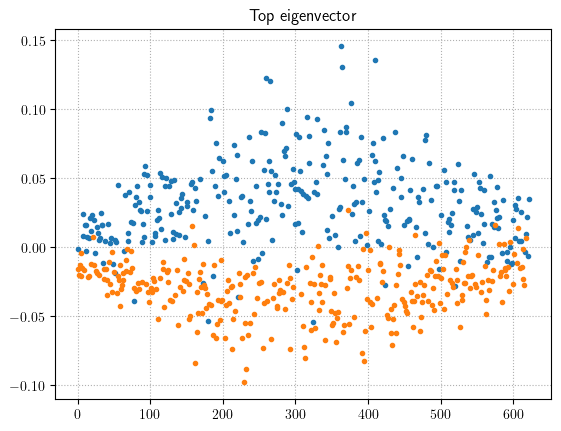

In [27]:
t = T//2
xx = np.arange(n)
for j in range(k):
    mask = (y[t-n+1:t+1] == j)
    plt.plot(xx[mask], w[t][mask], ls='', marker='.', color='C'+str(j))
plt.title("Top eigenvector")
plt.grid(ls=':')

In [28]:
# Batch
L_ = int(np.round((p/2)*(np.sqrt(1+4*M/(p*p))-1)))
print("L' = {}".format(L_))

for i in tqdm(range(int(np.ceil(T/L_)))):
    subX = X[i*L_:(i+1)*L_]
    subK = subX@subX.T/p # kernel matrix
    eigvals, eigvecs = eigsh(subK, k=1, which='LA') # dominant eigenvalue/eigenvector
    y_est[2][i*L_:(i+1)*L_] = np.where(eigvecs[:, -1] > 0, 0, 1) # class estimation
    _, per, _ = utils.get_classif_error(k, y_est[2][i*L_:(i+1)*L_], y[i*L_:(i+1)*L_])
    y_est[2][i*L_:(i+1)*L_] = per[y_est[2][i*L_:(i+1)*L_]]
c_err[2], _, _ = utils.get_classif_error(k, y_est[2], y)

L' = 231


100%|██████████| 87/87 [00:03<00:00, 26.65it/s]


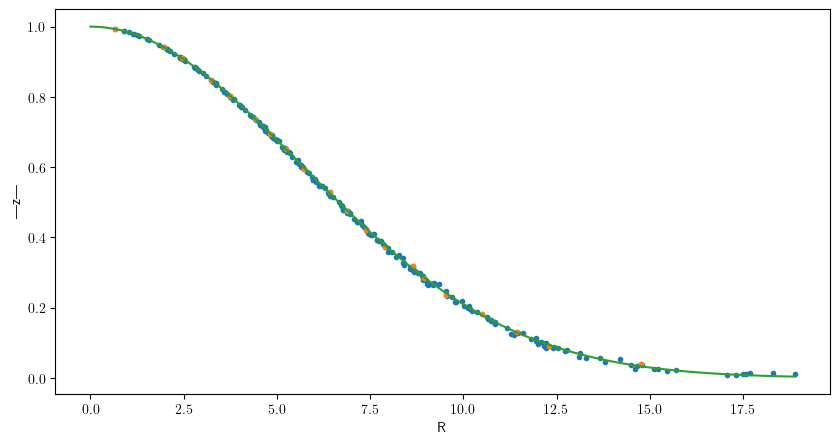

Computing sketch... Done.
Fitting k-means... Done.


In [29]:
# Sketching
X_bounded = (2*X-X.max()-X.min())/(X.max()-X.min()) # bound between -1 and 1
bounds = np.array([-np.ones(p), np.ones(p)])
m = int(M/(p+1)) # sketch size

Sigma = sk.estimate_Sigma(X_bounded, m0=m, n0=X_bounded.shape[0], verbose=1) # not realistic -> yields an optimistic error rate
Omega = sk.drawFrequencies("FoldedGaussian", p, m, Sigma)
Phi = sk.SimpleFeatureMap("ComplexExponential", Omega)

print("Computing sketch...", end='')
z = sk.computeSketch(X_bounded, Phi)
print(" Done.")

solver = cl.CLOMP_CKM(Phi, k, bounds, z)
print("Fitting k-means...", end='')
solver.fit_several_times(10)
print(" Done.")
centroids = solver.get_centroids()

dist = cdist(centroids, X_bounded, metric='euclidean')
y_est[3] = np.argmin(dist, axis=0)
c_err[3], _, _ = utils.get_classif_error(k, y_est[3], y)

# Results

In [30]:
print("{} vs {}".format(classes[0], classes[1]))
print("Offline   \t {:.5%}".format(c_err[0]))
print("Online    \t {:.5%}".format(c_err[1]))
print("Batch     \t {:.5%}".format(c_err[2]))
print("Sketching \t {:.5%}".format(c_err[3]))

collie vs tabby
Offline   	 5.38500%
Online    	 7.86000%
Batch     	 10.35000%
Sketching 	 47.84500%
